If needed upgrade google cloud aiplatform to >=1.36.0, you will need Python >=3.8

Once you upgrade your packages then restart your kernel

In [41]:
#pip install --user google-cloud-aiplatform --upgrade

In [1]:
!python3 --version

Python 3.10.13


In [3]:
from google.cloud import aiplatform
aiplatform.__version__

'1.36.1'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vertexai
from vertexai.language_models import CodeChatModel

In [22]:
PROJECT_ID="felipe-sandbox-354619"
MODEL="codechat-bison"

In [23]:
#inititate vertex code generation model
vertexai.init(project=PROJECT_ID, location="us-central1")
chat_model = CodeChatModel.from_pretrained(MODEL)
chat = chat_model.start_chat()

In [24]:
aiplatform.__version__

'1.36.1'

In [25]:
%%bigquery df
SELECT * FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE store_name = "WAL-MART 3394 / ATLANTIC"
AND date >= date("2023-01-01")

Query is running:   0%|          |

Downloading:   0%|          |

In [35]:
df['date'] = pd.to_datetime(df['date'])

In [36]:
pd.set_option('display.max_columns', None)
df_head = df.head(5)
df_head

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-60753500003,2023-07-28,3833,WAL-MART 3394 / ATLANTIC,1905 EAST 7TH ST,ATLANTIC,50022.0,POINT(-94.985986964 41.401588009),None,CASS,1012100.0,CANADIAN WHISKIES,434,LUXCO INC,10935,HAWKEYE CANADIAN WHISKY,6,1750,9.50,14.25,6,85.50,10.5,2.77
1,INV-57955300025,2023-04-28,3833,WAL-MART 3394 / ATLANTIC,1905 EAST 7TH ST,ATLANTIC,50022.0,POINT(-94.9859869639999 41.4015880090001),None,CASS,1031100.0,AMERICAN VODKAS,260,DIAGEO AMERICAS,37998,SMIRNOFF 80PRF,6,1750,14.75,22.13,6,132.78,10.5,2.77
2,INV-57114700013,2023-03-31,3833,WAL-MART 3394 / ATLANTIC,1905 EAST 7TH ST,ATLANTIC,50022,POINT(-94.9873 41.40387),None,CASS,1032100.0,IMPORTED VODKAS,370,PERNOD RICARD USA,34004,ABSOLUT SWEDISH VODKA 80PRF,24,375,4.99,7.49,24,179.76,9.0,2.37
3,INV-61597400020,2023-08-25,3833,WAL-MART 3394 / ATLANTIC,1905 EAST 7TH ST,ATLANTIC,50022.0,POINT(-94.985986964 41.401588009),None,CASS,1031100.0,AMERICAN VODKAS,421,SAZERAC COMPANY INC,35944,FLEISCHMANNS 80PRF VODKA,24,375,1.74,2.61,24,62.64,9.0,2.37
4,INV-59045500013,2023-06-03,3833,WAL-MART 3394 / ATLANTIC,1905 EAST 7TH ST,ATLANTIC,50022.0,POINT(-94.985986964 41.401588009),None,CASS,1042100.0,IMPORTED DRY GINS,260,DIAGEO AMERICAS,28868,TANQUERAY GIN,6,1750,26.49,39.74,6,238.44,10.5,2.77


In [37]:
df.dtypes

invoice_and_item_number            object
date                       datetime64[ns]
store_number                       object
store_name                         object
address                            object
city                               object
zip_code                           object
store_location                     object
county_number                      object
county                             object
category                           object
category_name                      object
vendor_number                      object
vendor_name                        object
item_number                        object
item_description                   object
pack                                Int64
bottle_volume_ml                    Int64
state_bottle_cost                 float64
state_bottle_retail               float64
bottles_sold                        Int64
sale_dollars                      float64
volume_sold_liters                float64
volume_sold_gallons               

In [27]:
df_head = df.head(10)
schema = df.dtypes

PREFIX = """
        Instructions:
        You are working with a pandas dataframe in Python. The name of the dataframe is `df`.
        Your job is to generate python code based on the questions asked by the user.
        This code should be ready to be executed inside a python environment therefore you do not need to include the "python" keyword.
        Please finish the code with a print statement or a plot of the results

        You can use the following libraries:
        - pandas
        - numpy
        - matplotlib

        This is the schema of the dataframe:
        {schema}
        This is the result of `print(df.head())`:
        {df_head}
        Begin!
        Question:""".format(df_head=df_head, schema=schema)

SUFFIX = """
        Answer:"""


def generate_pandas_code(prompt, prefix=PREFIX, suffix=SUFFIX ):

  parameters = {
      "candidate_count": 1,
      "max_output_tokens": 1024,
      "temperature": 0.2
  }

  prompt = prefix + prompt + suffix

  response = chat.send_message(prompt, **parameters).text
  print(response)
  # delete first line of the response
  edit_res = response.replace(response.split('\n')[0]+"\n", '')
  # delete last line of the response
  edit_res = edit_res.replace(edit_res.split('\n')[-1], '')

  return edit_res


def execute_code(code):
  try:
    print("Excecuting code...")
    print(eval(code))
    print("Done excecuting code...")
  except Exception as e:
    print(e)

In [28]:
prompt = "How many bottles were sold?"
execute_code(generate_pandas_code(prompt))

 ```python
df['bottles_sold'].sum()
```
Excecuting code...
17244
Done excecuting code...


In [38]:
prompt = "What was the total revenue for August of this year?"
execute_code(generate_pandas_code(prompt))

 ```python
df[df['date'].dt.month == 8]['sale_dollars'].sum()
```
Excecuting code...
31770.18
Done excecuting code...


In [33]:
prompt = "What were my top 10 categories in terms of bottles sold?"
execute_code(generate_pandas_code(prompt))

 ```python
df['category_name'].value_counts().nlargest(10)
```
Excecuting code...
category_name
AMERICAN VODKAS              347
CANADIAN WHISKIES            203
STRAIGHT BOURBON WHISKIES    138
SPICED RUM                   125
BLENDED WHISKIES              85
WHISKEY LIQUEUR               82
TENNESSEE WHISKIES            66
COCKTAILS/RTD                 62
WHITE RUM                     56
AMERICAN FLAVORED VODKA       52
Name: count, dtype: int64
Done excecuting code...


 ```python
df.groupby('date')['sale_dollars'].sum().plot()
```
Excecuting code...
Axes(0.125,0.2;0.775x0.68)
Done excecuting code...
Excecuting code...
eval() arg 1 must be a string, bytes or code object


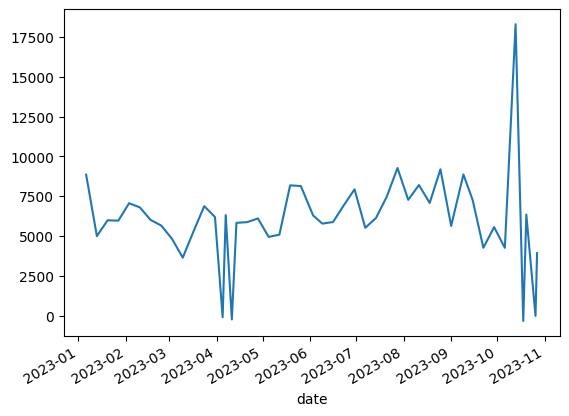

In [40]:
prompt = "Can you plot sales per day?"
execute_code(execute_code(generate_pandas_code(prompt)))